In [ ]:
with open (r"C:\Users\1\Desktop\vscode_test\TAMCAE\src\no_topology\log_128_2_7\train.log","r",encoding="utf-8") as f:
     lines = f.readlines()
     for i, line in enumerate(lines):
         if "✅ Model saved" in line:
             print(lines[i-1])

In [9]:
import pandas as pd
data = pd.read_csv(r"C:\Users\1\Desktop\vscode_test\TAMCAE\src\no_topology\Checkpoints_128_2_7\Checkpoints\train_log.csv")

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# ========= 全局绘图风格 =========
plt.rcParams.update({
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "lines.linewidth": 2,
    "figure.dpi": 200,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ========= 采样设置 =========
STEP_STRIDE = 1
AVG_WINDOW = 977     # 用最后多少个 step 计算平均
MARK_EVERY = 1

step = data.index[::STEP_STRIDE]

# ========= epoch → step 映射（只算一次） =========
epoch_steps = (
    data.groupby("epoch")
        .apply(lambda df: df.index.min())
        .to_numpy()
)

def plot_metric(
    y,
    ylabel,
    title,
    ylim=None,
    logy=False,
    color="C0",
):
    y_sampled = y.iloc[::STEP_STRIDE]

    fig, ax = plt.subplots(figsize=(6, 4))

    # ---- 主曲线 ----
    ax.plot(
        step,
        y_sampled,
        marker="o",
        markersize=1,
        markevery=MARK_EVERY,
        alpha=0.5,
        color=color,
    )

    # ---- 平均线（最后 AVG_WINDOW 个点）----
    avg_slice = y_sampled.iloc[-AVG_WINDOW:]
    avg_val = avg_slice.mean()

    ax.axhline(
        avg_val,
        color="red",
        linestyle="--",
        linewidth=1,
        label=f"Avg(last {AVG_WINDOW})",
    )

    ax.text(
        step[int(len(step) * 0.9)],
        avg_val * (1.5 if not logy else 1.5),
        f"{avg_val:.5f}",
        color="red",
        fontsize=10,
    )

    y_text_pos = -0.15  # 轴坐标系里的高度（0~1）

    for i, es in enumerate(epoch_steps, start=1):
        ax.axvline(
            es,
            color="red",
            linestyle=":",
            linewidth=1,
            alpha=1,
        )

        ax.text(
            es,
            y_text_pos + 0.05,
            f"Epoch{i}",
            color="red",
            fontsize=6,
            alpha=1,
            rotation=0,
            ha="center",
            va="bottom",
            transform=ax.get_xaxis_transform(),  # ⭐ 关键
        )

    # ---- 轴设置 ----
    if logy:
        ax.set_yscale("log")
    if ylim is not None:
        ax.set_ylim(*ylim)

    ax.set_xlabel("Step")
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    ax.grid(True, which="both", linestyle="--", alpha=0.35)
    fig.tight_layout()
    plt.show()


C:\Users\1\AppData\Local\Temp\ipykernel_36948\183181257.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.index.min())


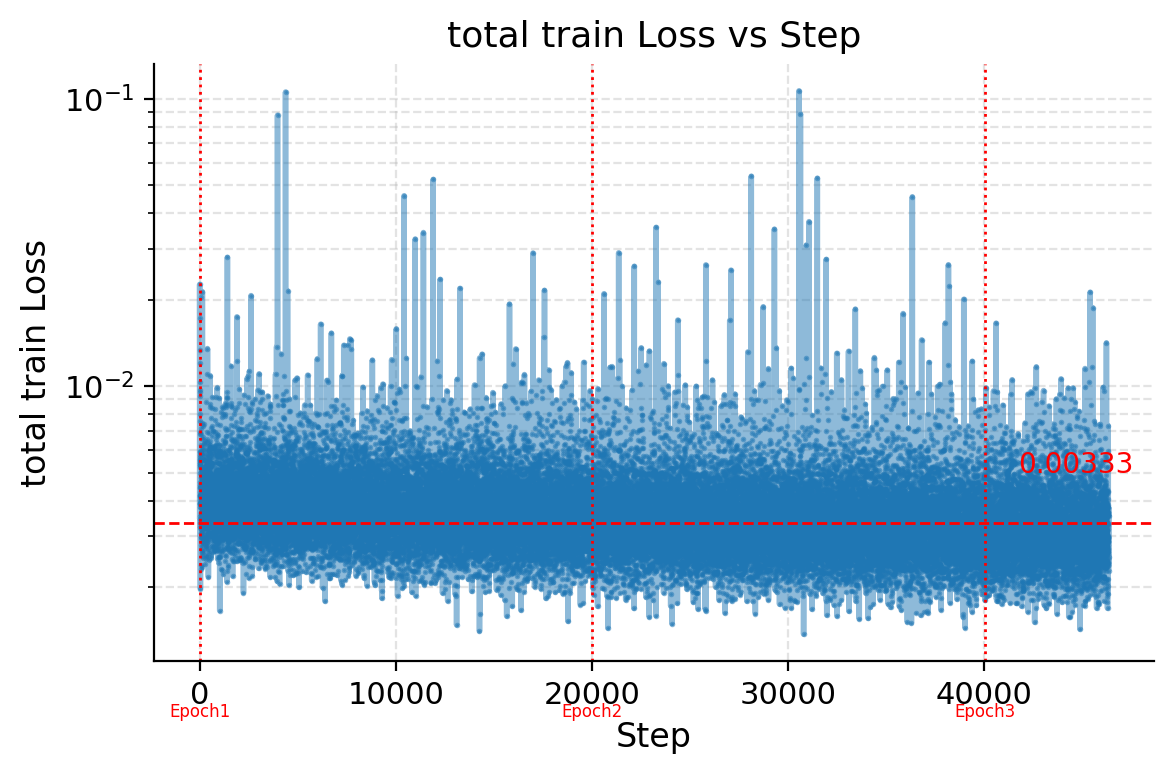

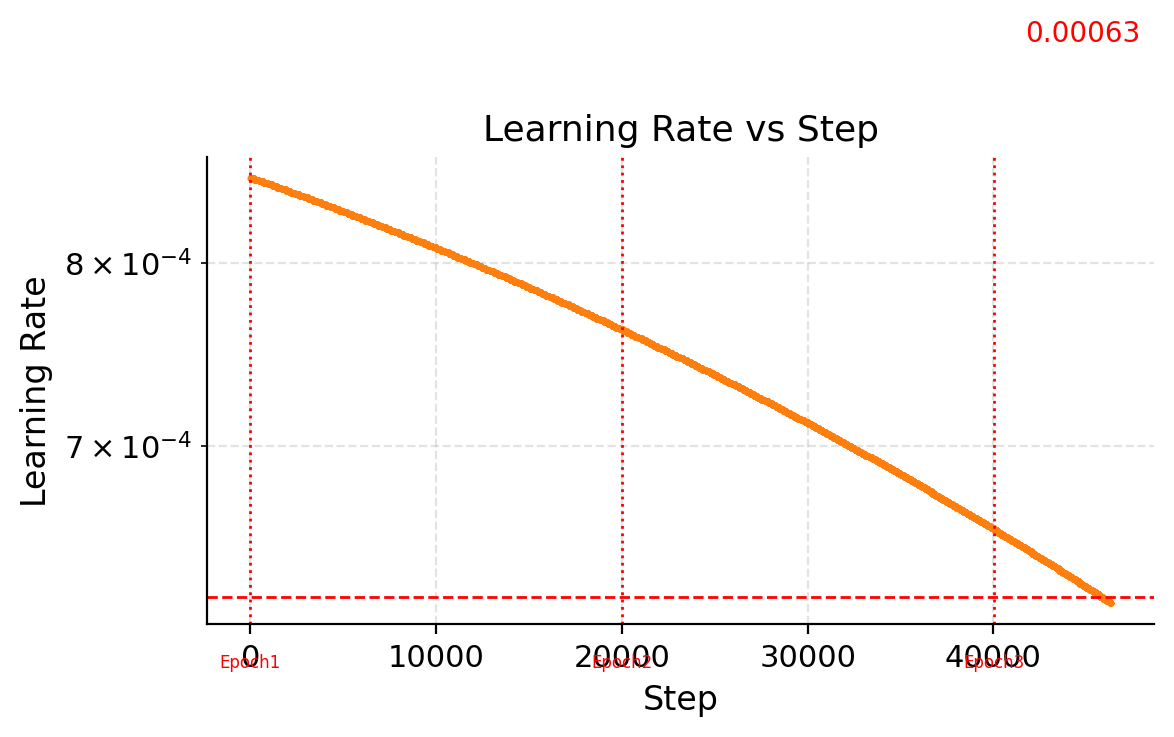

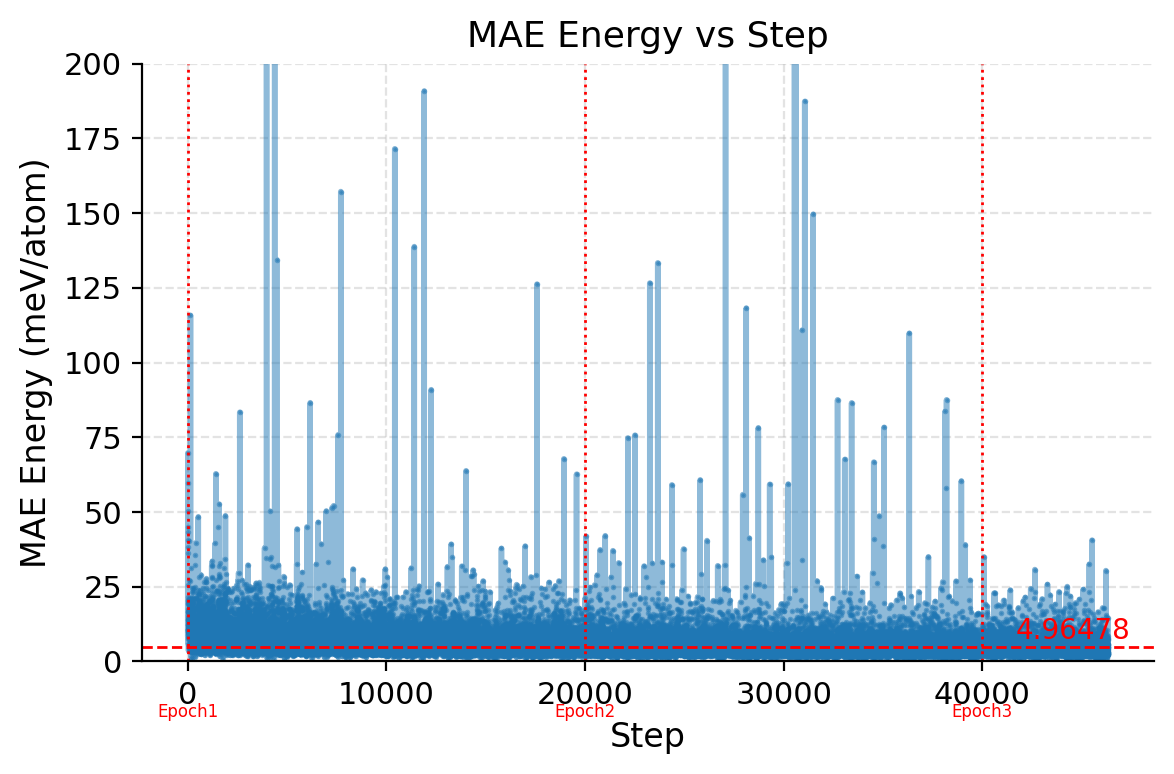

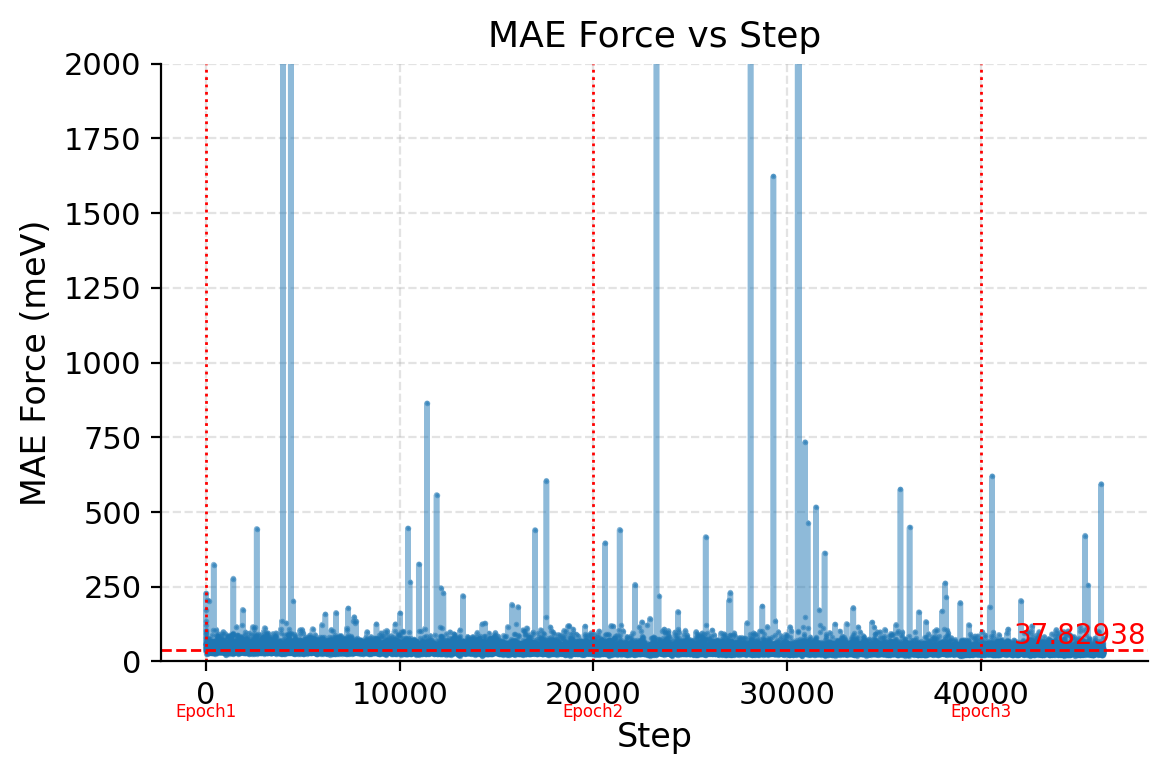

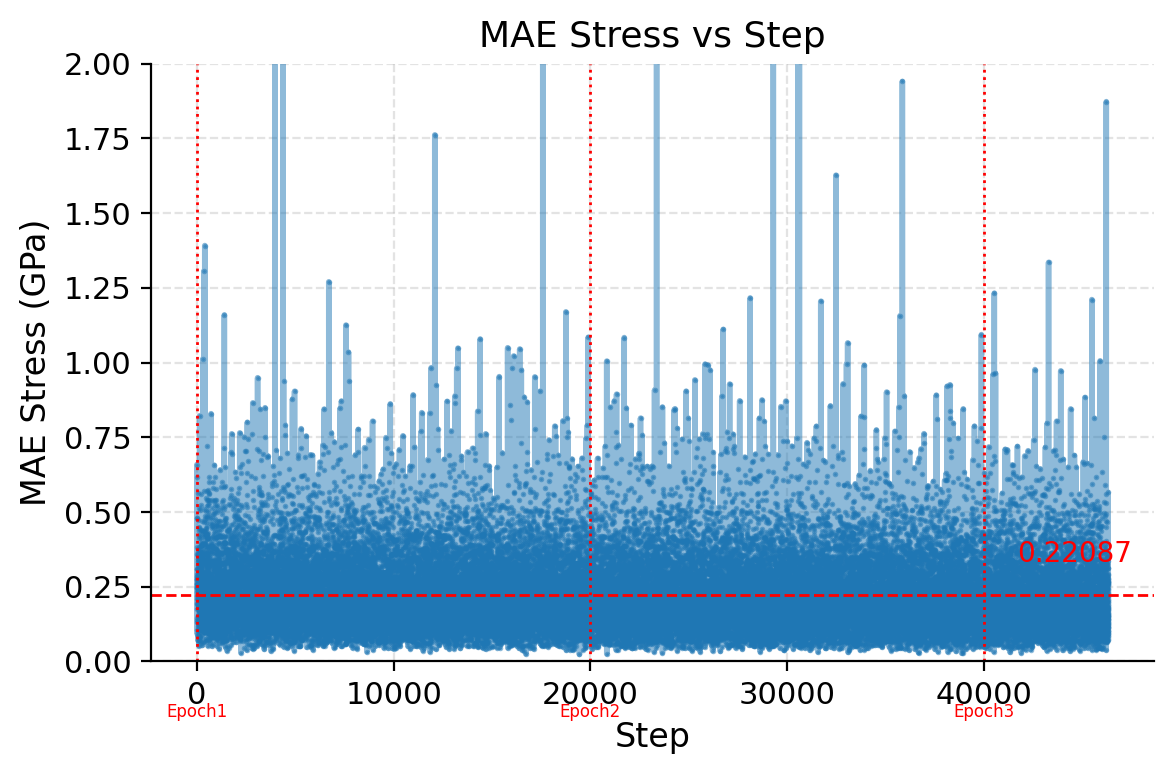

In [11]:
plot_metric(
    data["total_loss"],
    ylabel="total train Loss",
    title="total train Loss vs Step",
    logy=True,
)


plot_metric(
    data["lr"],
    ylabel="Learning Rate",
    title="Learning Rate vs Step",
    logy=True,
    color="C1",
)

plot_metric(
    data["mae_e"],
    ylabel="MAE Energy (meV/atom)",
    title="MAE Energy vs Step",
    ylim=(0, 200),
)

plot_metric(
    data["mae_f"],
    ylabel="MAE Force (meV)",
    title="MAE Force vs Step",
    ylim=(0, 2000),
)

plot_metric(
    data["mae_s_gpa"],
    ylabel="MAE Stress (GPa)",
    title="MAE Stress vs Step",
    ylim=(0, 2),
)

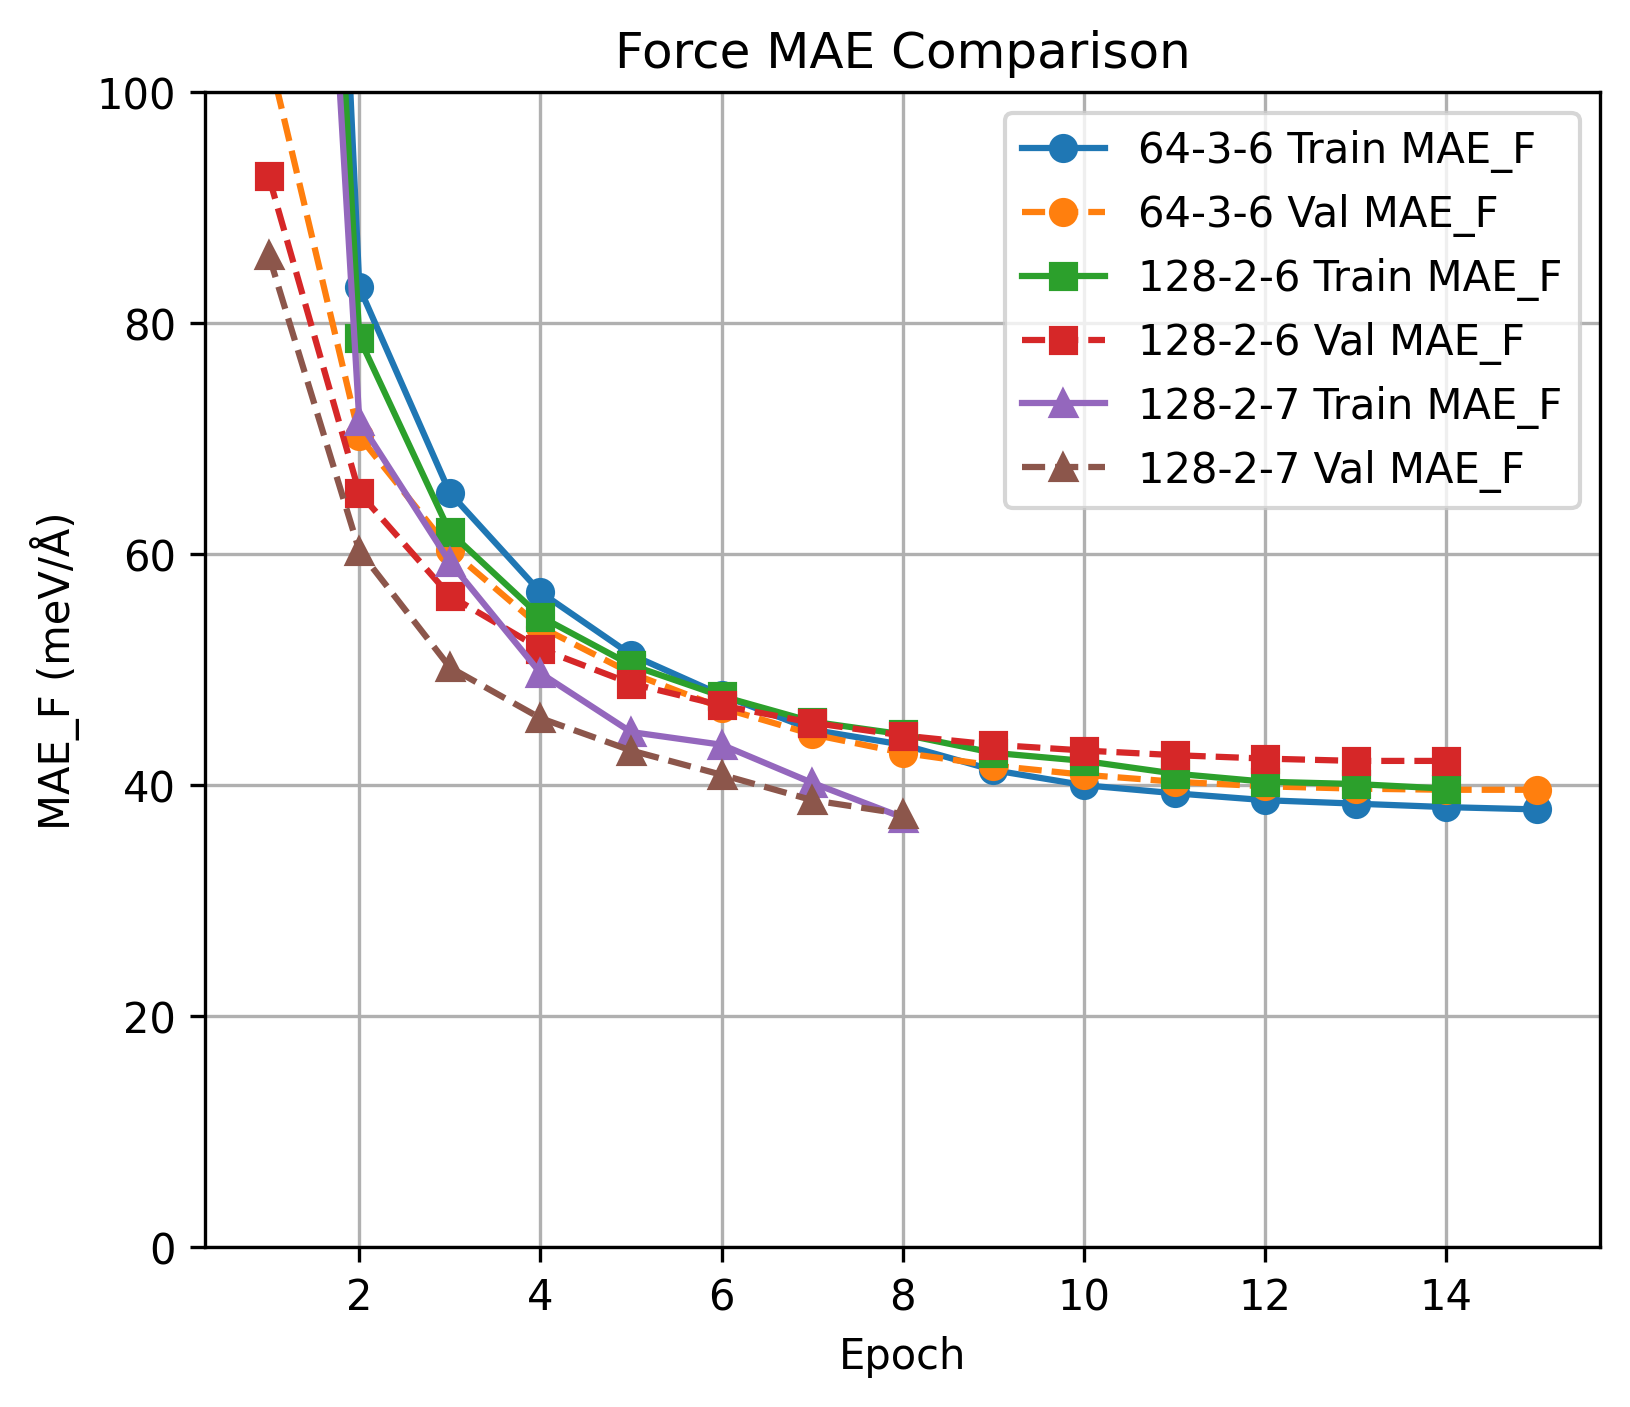

In [ ]:
import matplotlib.pyplot as plt

# =======================
# Run 1: 64-3-6
# =======================
epochs1 = list(range(1, 16))
mae_train_1 = [254.2, 83.1, 65.3, 56.7, 51.3, 47.8, 44.8, 43.5, 41.3, 40.0, 39.3, 38.7, 38.4, 38.1, 37.9]
mae_val_1   = [103.3, 70.2, 60.4, 53.7, 49.7, 46.7, 44.4, 42.8, 41.7, 40.9, 40.3, 39.9, 39.7, 39.6, 39.6]

# =======================
# Run 2: 128-2-6
# =======================
epochs2 = list(range(1, 15))
mae_train_2 = [216.7, 78.7, 61.9, 54.6, 50.4, 47.7, 45.5, 44.4, 42.8, 42.1, 41.0, 40.3, 40.1, 39.7]
mae_val_2   = [92.7, 65.3, 56.4, 51.8, 48.8, 46.9, 45.4, 44.3, 43.5, 43.0, 42.6, 42.3, 42.1, 42.1]

# =======================
# Run 3: 128-2-7
# =======================
epochs3 = [1, 2, 3, 4, 5, 6, 7, 8]
mae_train_3 = [204.6, 71.5, 59.3, 49.7, 44.6, 43.5, 40.2, 37.2， 35.2]
mae_val_3   = [85.9, 60.3, 50.2, 45.8, 43.0, 40.9, 38.7, 37.5, 36.4]

# =======================
# Plot
# =======================
plt.figure(figsize=(6, 5), dpi=300)

plt.plot(epochs1, mae_train_1, '-',  marker='o', label='64-3-6 Train MAE_F')
plt.plot(epochs1, mae_val_1,   '--', marker='o', label='64-3-6 Val MAE_F')

plt.plot(epochs2, mae_train_2, '-',  marker='s', label='128-2-6 Train MAE_F')
plt.plot(epochs2, mae_val_2,   '--', marker='s', label='128-2-6 Val MAE_F')

plt.plot(epochs3, mae_train_3, '-',  marker='^', label='128-2-7 Train MAE_F')
plt.plot(epochs3, mae_val_3,   '--', marker='^', label='128-2-7 Val MAE_F')

plt.xlabel("Epoch")
plt.ylim(0, 100)
plt.ylabel("MAE_F (meV/Å)")
plt.title("Force MAE Comparison")
plt.legend()
plt.grid(True)

plt.show()

In [1]:
import torch
import sys
import os

# 1. Define the path where the REAL 'src' package (Folder B) lives
real_src_path = r"C:\Users\1\Desktop\vscode_test\TAMCAE\src\no_topology"

# 2. Insert it at position 0 (the very start) so Python sees it BEFORE the wrong 'src'
if real_src_path not in sys.path:
    sys.path.insert(0, real_src_path)

# Optional: Verify that data.py actually exists in the place we are pointing to
# This should print a list containing 'data.py', 'models.py', etc.
print("Contents of the target src folder:", os.listdir(os.path.join(real_src_path, "src")))

# 3. Now import
from src.data import ChunkedSmartDataset
from src.data import BinPackingSampler
from src.models import HTGPModel
from src.utils import HTGPConfig
from src.engine import PotentialTrainer 

# Load weights
for i in range(18):
    state_dict = torch.load(rf"C:\Users\1\Desktop\vscode_test\TAMCAE\src\no_topology\Charged_ft\Checkpoints_ft_init_q\model_epoch_{i+1}_ft.pt", map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'), weights_only=False)
    model = HTGPModel(state_dict["model_config"])
    model.load_state_dict(state_dict["model_state_dict"], strict=False)
    print(f"Sigma exact value: {model.long_range.sigma.item():.10f}")
    # print(f"weights {model.layers[1].gating.W_query.weight}")
    # print(model.cfg)

Contents of the target src folder: ['data', 'engine', 'models', 'utils', '__init__.py', '__pycache__']


d:\software\miniconda\envs\env_test_1\Lib\site-packages\torch_geometric\__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not load this library: D:\software\miniconda\envs\env_test_1\Lib\site-packages\torch_scatter\_version_cuda.pyd
  import torch_geometric.typing
d:\software\miniconda\envs\env_test_1\Lib\site-packages\torch_geometric\__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: Could not load this library: D:\software\miniconda\envs\env_test_1\Lib\site-packages\torch_cluster\_version_cuda.pyd
  import torch_geometric.typing
d:\software\miniconda\envs\env_test_1\Lib\site-packages\torch_geometric\__init__.py:4: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: Could not load this library: D:\software\miniconda\envs\env_test_1\Lib\site-packages\torch_spline_conv\_version_cuda.pyd
  import torch_geometric.

>>> 警告: 已对电荷投影层进行暴力初始化 (std=0.2)，旨在打破零梯度陷阱。
Sigma exact value: 1.0909042358
>>> 警告: 已对电荷投影层进行暴力初始化 (std=0.2)，旨在打破零梯度陷阱。
Sigma exact value: 1.1494742632
>>> 警告: 已对电荷投影层进行暴力初始化 (std=0.2)，旨在打破零梯度陷阱。
Sigma exact value: 1.1777163744
>>> 警告: 已对电荷投影层进行暴力初始化 (std=0.2)，旨在打破零梯度陷阱。
Sigma exact value: 1.2323364019
>>> 警告: 已对电荷投影层进行暴力初始化 (std=0.2)，旨在打破零梯度陷阱。
Sigma exact value: 1.2466498613
>>> 警告: 已对电荷投影层进行暴力初始化 (std=0.2)，旨在打破零梯度陷阱。
Sigma exact value: 1.2925709486
>>> 警告: 已对电荷投影层进行暴力初始化 (std=0.2)，旨在打破零梯度陷阱。
Sigma exact value: 1.3123705387
>>> 警告: 已对电荷投影层进行暴力初始化 (std=0.2)，旨在打破零梯度陷阱。
Sigma exact value: 1.3398255110
>>> 警告: 已对电荷投影层进行暴力初始化 (std=0.2)，旨在打破零梯度陷阱。
Sigma exact value: 1.3500961065
>>> 警告: 已对电荷投影层进行暴力初始化 (std=0.2)，旨在打破零梯度陷阱。
Sigma exact value: 1.3531804085
>>> 警告: 已对电荷投影层进行暴力初始化 (std=0.2)，旨在打破零梯度陷阱。
Sigma exact value: 1.3589297533
>>> 警告: 已对电荷投影层进行暴力初始化 (std=0.2)，旨在打破零梯度陷阱。
Sigma exact value: 1.3876250982
>>> 警告: 已对电荷投影层进行暴力初始化 (std=0.2)，旨在打破零梯度陷阱。
Sigma exact value: 1.3958607912
>>> 警告: 已对电荷

In [ ]:
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

prev_weight = None  # 保存前一个 checkpoint 的 weight

for i in range(1):
    ckpt_path = rf"C:\Users\1\Desktop\vscode_test\TAMCAE\src\no_topology\Charged_ft\Checkpoints_ft_charge_larger_lr\model_epoch_{i+1}_ft.pt"

    state_dict = torch.load(
        ckpt_path,
        map_location=device,
        weights_only=False
    )

    model = HTGPModel(state_dict["model_config"]).to(device)
    model.load_state_dict(state_dict["model_state_dict"], strict=False)
    model.eval()

    # 当前 weight（注意 clone，防止被后面覆盖）
    curr_weight = model.long_range.q_proj[2].weight.detach().clone()

    if prev_weight is not None:
        delta = curr_weight - prev_weight

        # 你可以按需要看不同统计量
        print(
            f"Epoch {i:02d} → {i+1:02d} | "
            f"ΔW: mean={delta.mean().item():+.3e}, "
            f"std={delta.std().item():.3e}, "
            f"max={delta.abs().max().item():.3e}"
        )

    else:
        print(f"Epoch {i+1:02d}: baseline (no delta)")

    prev_weight = curr_weight


In [ ]:
for i, j in model.named_parameters():
    print(i)

In [ ]:
NONTARGET_REFCODES = [
    "HALTUL",
    "JUVYAA01",
    "RELKUR",
    "VUKDIO",
    "ULISAJ",
    "MOSDOR",
    "MEGXOL",
    "ANLPCP",
    "VARSUG",
    "OXBMOB",
    "DIFZEX",
    "RASNIM",
    "VUKDOU",
    "GOZLIT",
    "ATIHUJ",
    "ARESOG",
    "HUSHIO",
    "HUSJAI",
    "IDIHOT",
    "IMOQOQ",
    "KOGLIC",
    "REZRAT",
    "RIVYAA",
    "SIHLED",
    'WINGIM', 'WINGEI', 'AQEZOO', 'GUGNAX', 'GOBNUJ', 'WAFYAD', 'TECNAQ10', 'TOJKUB','QEVSUF','WINFUX', 'WUPVEL','MUJCOJ','JINVEI','OCOZUF','DICWIV','ZZZUQO02', 'ZUHVEF','JAFHUT', 'IHAWOD','AJESEQ',
]

In [ ]:
import torch
import numpy as np
import json
import os
import sys
# 获取当前 notebook 所在的目录
sys.path.append(r"C:\Users\1\Desktop\vscode_test\TAMCAE\src\no_topology")
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch_geometric.loader import DataLoader

# --- 导入自定义模块 ---
from src.data import ChunkedSmartDataset   # 👈 新的数据集
from src.data import BinPackingSampler # 👈 新的采样器
from src.models import HTGPModel
from src.utils import HTGPConfig
from src.engine import PotentialTrainer 

config = HTGPConfig(
    num_atom_types=55, 
    hidden_dim=64, 
    num_layers=3, 
    cutoff=6.0, 
    num_rbf=10,
    use_L0=True, 
    use_L1=True,
    use_L2=True, 
    use_gating=True, 
    use_long_range=False,
    use_charge=False,
    avg_neighborhood=89,
    FINETUNE_MODE=False
)

# build model
model = HTGPModel(config)
# load model parameters
path = r"C:\Users\1\Desktop\vscode_test\TAMCAE\src\no_topology\Checkpoints_64_3_6\model_epoch_15.pt"
state_dict = torch.load(path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


# path = r"C:\Users\1\Desktop\vscode_test\TAMCAE\src\no_topology\Checkpoints_128_2_6\model_epoch_14.pt"
# Checkpoints = torch.load(path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'), weights_only=False)
# state_dict = Checkpoints["model_state_dict"]
# config = Checkpoints["model_config"]
# # config.avg_neighborhood = 89
# model = HTGPModel(config)
new_state_dict = {}
for k, v in state_dict.items():
    # 如果键以 module. 开头，去掉这 7 个字符
    if k.startswith('module.'):
        name = k[7:] 
    else:
        name = k
    new_state_dict[name] = v
try:
    model.load_state_dict(new_state_dict, strict=True)
    print("✅ 模型参数加载成功！")
except RuntimeError as e:
    print(f"❌ 加载依然失败，请检查 Config 是否与训练一致。\n详细错误: {e}")
# 总参数
total_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数量: {total_params}")
# 模型是32还是64精度
dtypes = {p.dtype for p in model.parameters()}

if dtypes == {torch.float32}:
    print("模型参数精度: float32 (FP32)")
elif dtypes == {torch.float64}:
    print("模型参数精度: float64 (FP64)")
else:
    print("模型参数包含多种精度:", dtypes)
    
# 打印cfg
print(model.cfg)
# print(model.atomic_ref.weight)

In [ ]:
# import h5py
# import numpy as np
# import torch
# from ase import Atoms
# from ase.units import Bohr, Hartree

# # 假设你的模型定义和加载在这里
# from src.utils import HTGP_Calculator

# # ================= 配置区域 =================
# filepath = r"E:\SPICE-1.1.4.hdf5"  # 请确保路径正确
# max_molecules = 500                 # 设为 None 跑全量，建议先跑 20 个测试
# # ===========================================

# # 1. 准备单位转换系数
# TO_ANGSTROM = Bohr  
# TO_EV_ANGSTROM = Hartree / Bohr 

# # 初始化
# all_mae_errors = []
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"Device: {device}")

# # --- [此处加载模型] ---
# # 假设 model 变量已存在，或者在这里初始化
# calculator = HTGP_Calculator(model, cutoff=6.0, device=device)

# print(f"开始读取数据集: {filepath}")

# with h5py.File(filepath, 'r') as f:
#     mol_ids = list(f.keys())
#     print(f"总共{len(mol_ids)}个分子")

#     # 稍微扩大一点搜索范围，因为很多分子可能会被过滤掉
#     # 如果想跑全量，把下面这行注释掉
#     if max_molecules:
#         mol_ids = mol_ids[:max_molecules*5] 

#     print(f"正在扫描并筛选 PubChem 中性分子...")
    
#     count_valid = 0

#     for mol_name in mol_ids:
#         # 如果已经测够了数量，就停止（仅用于快速测试）
#         if max_molecules and count_valid >= max_molecules:
#             break

#         group = f[mol_name]
        
#         # -----------------------------------------------------------
#         # [过滤器 1] 子集筛选: 只看 "PubChem"
#         # -----------------------------------------------------------
#         if 'subset' not in group:
#             continue
            
#         # HDF5 中的字符串通常是 bytes，需要 decode
#         subset_str = group['subset'][0].decode('utf-8')
        
#         # 如果不是 PubChem 来源，直接跳过
#         if "PubChem" not in subset_str:
#             continue
            
#         # -----------------------------------------------------------
#         # [过滤器 2] 电荷筛选: 只看中性分子
#         # -----------------------------------------------------------
#         is_neutral = False
        
#         if 'mbis_charges' in group:
#             qs = group['mbis_charges'][0]
#             # 严格判断总电荷是否接近 0
#             if abs(np.sum(qs)) < 0.01:
#                 is_neutral = True
        
#         if not is_neutral:
#             continue
            
#         # -----------------------------------------------------------
#         # [数据完整性检查]
#         # -----------------------------------------------------------
#         if 'dft_total_gradient' not in group or 'conformations' not in group:
#             continue

#         # 如果代码走到这里，说明这既是 PubChem 分子，又是中性的，且数据完整
#         count_valid += 1
        
#         # --- 数据读取与计算 ---
#         atomic_numbers = group['atomic_numbers'][:]
#         conformations_bohr = group['conformations'][:]          
#         gradients_hartree_bohr = group['dft_total_gradient'][:] 
        
#         num_conformations = conformations_bohr.shape[0]

#         for i in range(num_conformations):
#             # 1. 坐标转换: Bohr -> Angstrom
#             pos_angstrom = conformations_bohr[i] * TO_ANGSTROM
            
#             # 2. 力转换: Gradient -> Force (-1.0) & Hartree/Bohr -> eV/Angstrom
#             forces_true = -1.0 * gradients_hartree_bohr[i] * TO_EV_ANGSTROM
            
#             # 3. ASE 计算
#             atoms = Atoms(numbers=atomic_numbers, positions=pos_angstrom)
#             atoms.calc = calculator
            
#             try:
#                 forces_pred = atoms.get_forces()
#             except Exception as e:
#                 print(f"计算失败: {mol_name}, Error: {e}")
#                 continue
            
#             # 4. 误差记录
#             diff = forces_pred - forces_true
#             mae = np.mean(np.abs(diff))
#             all_mae_errors.append(mae)

#         # 打印进度
#         if count_valid % 1 == 0:
#             print(f"[{count_valid}] 已处理: {subset_str} | ID: {mol_name} | 构象数: {num_conformations}")

# # --- 结果统计 ---
# all_mae_errors = np.array(all_mae_errors)

# if len(all_mae_errors) > 0:
#     print("\n" + "="*40)
#     print(f"【PubChem 中性分子 测试结果】")
#     print("-" * 40)
#     print(f"有效分子数 (Molecules) : {count_valid}")
#     print(f"评估构象数 (Confs)     : {len(all_mae_errors)}")
#     print(f"Mean Force MAE         : {np.mean(all_mae_errors):.6f} eV/Å")
#     print(f"Force RMSE             : {np.sqrt(np.mean(all_mae_errors**2)):.6f} eV/Å")
#     print("="*40)
# else:
#     print("\n未找到符合条件的数据。请检查：")
#     print("1. 数据集是否包含 PubChem 子集？")
#     print("2. 是否因为 max_molecules 设置太小，前面全是肽类数据？")

In [ ]:
"""正在检查文件: E:\SPICE-1.1.4.hdf5
总条目数: 19238

正在扫描所有分子...
========================================
【数据集中的子集名称分布】
  - SPICE PubChem Set 6 Single Points Dataset v1.2: 2476 个
  - SPICE PubChem Set 2 Single Points Dataset v1.2: 2431 个
  - SPICE PubChem Set 1 Single Points Dataset v1.2: 2372 个
  - SPICE PubChem Set 3 Single Points Dataset v1.2: 2446 个
  - SPICE PubChem Set 4 Single Points Dataset v1.2: 2455 个
  - SPICE PubChem Set 5 Single Points Dataset v1.2: 2463 个
  - SPICE DES370K Single Points Dataset Supplement v1.0: 93 个
  - SPICE Ion Pairs Single Points Dataset v1.1: 28 个
  - SPICE DES370K Single Points Dataset v1.0: 3397 个
  - SPICE DES Monomers Single Points Dataset v1.1: 374 个
  - SPICE Solvated Amino Acids Single Points Dataset v1.1: 26 个
  - SPICE Dipeptides Single Points Dataset v1.2: 677 个
"""

import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt  # <--- 新增
from ase import Atoms
from ase.units import Bohr, Hartree
from scipy.stats import pearsonr
from src.utils import HTGP_Calculator

# ================= 配置区域 =================
filepath = r"E:\SPICE-1.1.4.hdf5"
max_molecules = 50   # 调试建议先用 50，确认无误后改为 None 跑全量
LOW_ENERGY_CUTOFF = 0.1   # eV

# -------- 电荷分类选择 --------
# "neutral" | "ionic-neutral" | "net-charged" | "all"
SELECT_LABEL = "ionic-neutral" 
CHARGE_TOL = 0.01
# --------------------------------

TO_ANGSTROM = Bohr
TO_EV_ANGSTROM = Hartree / Bohr
TO_EV = Hartree
# ===========================================

# 定义数据容器
forces_low_true  = {"neutral": [], "ionic-neutral": [], "net-charged": []}
forces_low_pred  = {"neutral": [], "ionic-neutral": [], "net-charged": []}
forces_high_true = {"neutral": [], "ionic-neutral": [], "net-charged": []}
forces_high_pred = {"neutral": [], "ionic-neutral": [], "net-charged": []}

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# 初始化计算器 (假设 model 已存在)
if 'model' not in locals():
    print("提示: 确保代码上下文中有 'model' 变量。")
    # model = torch.load("best_model.pt")

calculator = HTGP_Calculator(
    model,
    cutoff=6.0,
    device=device,
    capture_weights=True,
    capture_descriptors=True
)

print(f"开始读取数据集: {filepath}")

# ================= 数据读取 =================
with h5py.File(filepath, 'r') as f:
    mol_ids = list(f.keys())
    scan_ids = mol_ids[:max_molecules * 10] if max_molecules else mol_ids
    count_valid = 0

    for mol_name in scan_ids:
        if max_molecules and count_valid >= max_molecules:
            break

        group = f[mol_name]

        # Filter: PubChem
        if 'subset' not in group: continue
        try:
            subset_str = group['subset'][0].decode('utf-8')
        except: continue
        if "PubChem" not in subset_str: continue

        # Filter: Charge Info
        net_charge = None
        has_ionic_symbol = False
        if 'mbis_charges' in group:
            qs = group['mbis_charges'][0]
            net_charge = float(np.sum(qs))
        if 'smiles' in group:
            try:
                smi = group['smiles'][0].decode('utf-8')
                if '+' in smi or '-' in smi: has_ionic_symbol = True
            except: pass
        if net_charge is None: continue

        # Labeling
        if abs(net_charge) >= CHARGE_TOL:
            charge_label = "net-charged"
        else:
            charge_label = "ionic-neutral" if has_ionic_symbol else "neutral"

        if SELECT_LABEL != "all" and charge_label != SELECT_LABEL:
            continue

        # Data Integrity
        if 'dft_total_gradient' not in group or 'conformations' not in group: continue
        
        if 'formation_energy' in group:
            energies_ha = group['formation_energy'][:]
        elif 'dft_total_energy' in group:
            energies_ha = group['dft_total_energy'][:]
        else: continue

        # Load Arrays
        atomic_numbers = group['atomic_numbers'][:]
        conformations_bohr = group['conformations'][:]
        gradients_hartree_bohr = group['dft_total_gradient'][:]

        count_valid += 1

        # Energy & Forces
        min_e = np.min(energies_ha)
        delta_e_ev = (energies_ha - min_e) * TO_EV
        num_confs = conformations_bohr.shape[0]

        if count_valid % 20 == 0:
            print(f"[{count_valid}] {mol_name} | label={charge_label} | confs={num_confs}")

        for i in range(num_confs):
            is_high_energy = delta_e_ev[i] > LOW_ENERGY_CUTOFF
            pos_angstrom = conformations_bohr[i] * TO_ANGSTROM
            forces_true = -gradients_hartree_bohr[i] * TO_EV_ANGSTROM

            atoms = Atoms(numbers=atomic_numbers, positions=pos_angstrom)
            atoms.calc = calculator
            try:
                forces_pred = atoms.get_forces()
            except: continue

            true_flat = forces_true.reshape(-1)
            pred_flat = forces_pred.reshape(-1)

            if is_high_energy:
                forces_high_true[charge_label].append(true_flat)
                forces_high_pred[charge_label].append(pred_flat)
            else:
                forces_low_true[charge_label].append(true_flat)
                forces_low_pred[charge_label].append(pred_flat)


# ================= 数据合并 =================
def concat_forces(d):
    return {k: np.concatenate(v) if len(v) > 0 else np.array([]) for k, v in d.items()}

forces_low_true  = concat_forces(forces_low_true)
forces_low_pred  = concat_forces(forces_low_pred)
forces_high_true = concat_forces(forces_high_true)
forces_high_pred = concat_forces(forces_high_pred)


# ================= 统计函数 (带返回值) =================
def calc_metrics(y_true, y_pred, title, verbose=False):
    """
    计算统计量，打印并返回结果 (MAE, RMSE, R, k, b)
    """
    if len(y_true) == 0:
        if verbose: print(f">>> {title}: 无数据")
        else: print(f"  {title:<10} | 无数据")
        return None

    diff = y_pred - y_true
    mae = np.mean(np.abs(diff))
    rmse = np.sqrt(np.mean(diff**2))
    r, _ = pearsonr(y_true, y_pred)
    
    # 线性拟合
    k, b = np.polyfit(y_true, y_pred, 1)

    if not verbose:
        print(f"  {title:<10} | N_pts={len(y_true):<9} | MAE={mae:.6f} | RMSE={rmse:.6f}")
    else:
        print(f">>> {title} ({len(y_true)} points)")
        print(f"    MAE      : {mae:.4f} eV/Å")
        print(f"    RMSE     : {rmse:.4f} eV/Å")
        print(f"    Pearson R: {r:.4f}")
        print(f"    Fit Line : y = {k:.4f}x + {b:.4f}")
        print("-" * 40)
    
    return mae, rmse, r, k, b

# ================= 结果输出 =================
print("\n" + "=" * 80)
print("【PubChem | Force Error Statistics (Micro-averaged)】")
print(f"有效分子数: {count_valid}")
print("=" * 80)

labels_to_show = [SELECT_LABEL] if SELECT_LABEL != "all" else ["neutral", "ionic-neutral", "net-charged"]

# 1. 打印摘要
for label in labels_to_show:
    print(f"\n[{label.upper()}]")
    print("-" * 60)
    calc_metrics(forces_low_true[label], forces_low_pred[label], "Low-E")
    calc_metrics(forces_high_true[label], forces_high_pred[label], "High-E")

print("\n" + "=" * 80)
print("【详细分析 & 绘图】")

# 2. 详细分析并绘图
for label in labels_to_show:
    print(f"\n处理标签组: {label.upper()}")
    
    # 获取数据
    low_true = forces_low_true[label]
    low_pred = forces_low_pred[label]
    high_true = forces_high_true[label]
    high_pred = forces_high_pred[label]

    # 计算详细统计量 (并获取返回值供绘图使用)
    stats_low = calc_metrics(low_true, low_pred, "Low Energy", verbose=True)
    stats_high = calc_metrics(high_true, high_pred, "High Energy", verbose=True)

    # 如果没有数据，跳过绘图
    if stats_low is None and stats_high is None:
        continue

    # ================= 绘图代码 (你的代码嵌入在此) =================
    print(f"正在生成 {label} 的散点图...")
    plt.figure(figsize=(8, 7), dpi=150)

    # 绘制 High Energy (用浅红色，先画作为背景)
    if stats_high is not None and len(high_true) > 0:
        plt.scatter(high_true, high_pred, alpha=0.3, s=5, c='salmon', 
                    label=f'High Energy (R={stats_high[2]:.3f})') # stats[2] is Pearson R

    # 绘制 Low Energy (用深蓝色，后画更清晰)
    if stats_low is not None and len(low_true) > 0:
        plt.scatter(low_true, low_pred, alpha=0.3, s=5, c='teal', 
                    label=f'Low Energy (R={stats_low[2]:.3f})')   # stats[2] is Pearson R

    # 确定坐标轴范围
    # 简单合并所有存在的数据来找最大最小值
    valid_trues = [arr for arr in [low_true, high_true] if len(arr) > 0]
    if not valid_trues: continue # 双重保险
    
    all_min = min([np.min(arr) for arr in valid_trues])
    all_max = max([np.max(arr) for arr in valid_trues])
    
    # 稍微拓宽一点视野
    margin = (all_max - all_min) * 0.05
    plot_min, plot_max = all_min - margin, all_max + margin

    # 绘制对角线 (理想预测)
    plt.plot([plot_min, plot_max], [plot_min, plot_max], 'k--', lw=1.5, label='Ideal (y=x)')

    plt.xlabel(r'DFT Forces ($\omega$B97M) [eV/$\AA$]')
    plt.ylabel(r'MLP Forces (PBE-trained) [eV/$\AA$]')
    plt.title(f'Force Correlation: PBE Model vs SPICE\nSubset: {label.upper()}')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    
    plt.xlim(plot_min, plot_max)
    plt.ylim(plot_min, plot_max)
    plt.tight_layout()
    plt.show()
    # ==========================================================

print("完成。")

Device: cuda
开始读取数据集: E:\SPICE-1.1.4.hdf5
[DEBUG] h0 stats: mean=0.16613, std=0.21168
[DEBUG] W stats: mean=0.11814, std=0.15384
Charge q info: mean=0.00135, max=0.01132
to see how much of e_long: tensor(-0.0007, device='cuda:0', grad_fn=<MulBackward0>)
[DEBUG] h0 stats: mean=0.16564, std=0.21087
[DEBUG] W stats: mean=0.11814, std=0.15384
Charge q info: mean=0.00136, max=0.01396
to see how much of e_long: tensor(-0.0008, device='cuda:0', grad_fn=<MulBackward0>)
[DEBUG] h0 stats: mean=0.16615, std=0.21163
[DEBUG] W stats: mean=0.11814, std=0.15384
Charge q info: mean=0.00138, max=0.01218
to see how much of e_long: tensor(-0.0008, device='cuda:0', grad_fn=<MulBackward0>)
[DEBUG] h0 stats: mean=0.16622, std=0.21188
[DEBUG] W stats: mean=0.11814, std=0.15384
Charge q info: mean=0.00136, max=0.01053
to see how much of e_long: tensor(-0.0007, device='cuda:0', grad_fn=<MulBackward0>)
[DEBUG] h0 stats: mean=0.16593, std=0.21136
[DEBUG] W stats: mean=0.11814, std=0.15384
Charge q info: mean=0.0

In [ ]:
# 4. 获取 Weights 和 Descriptors
# 它们现在躺在 atoms.calc.results 字典里

# --- 获取 Attention Weights ---
if 'weights' in atoms.calc.results:
    weights = atoms.calc.results['weights']
    print("\n=== Attention Weights ===")
    print(f"Total layers: {len(weights)}")
    # 查看第一层的 g0 门控权重
    print(f"Layer 0 - g0 shape: {weights[0]['g0'].shape}") 
    # (N_atoms, Hidden_Dim)

# --- 获取 Descriptors -- -
if 'descriptors' in atoms.calc.results:
    descriptors = atoms.calc.results['descriptors']
    print("\n=== Atom Descriptors ===")
    print(f"Total layers: {len(descriptors)}")
    # 查看最后一层输出的标量特征 h0
    last_layer_h0 = descriptors[-1]['h0']
    print(f"Last Layer h0 shape: {last_layer_h0.shape}")
    # (N_atoms, Hidden_Dim)

In [ ]:
weights[0].get("p_ij")

In [ ]:
from src.utils import HTGP_Calculator
calculator = HTGP_Calculator(model, cutoff=6.0, device="cuda" if torch.cuda.is_available() else "cpu")
from tqdm import tqdm
from ase.io import read
data_path = r"C:\Users\1\Desktop\vscode_test\Omatbench\main\Structure_files\Cocrystal_init_str\AQEZOO.cif"
# data_path = r"C:\Users\1\Desktop\vscode_test\Omatbench\main\Structure_files\Task_1.xyz"
atoms = read(data_path, index=":")
import os
errors_force_all = []
Task_1_list = [cif.split(".")[0] for cif in os.listdir(r"C:\Users\1\Desktop\Task_1") if cif.endswith(".cif")]
# for atoms in tqdm(atoms_list):
#      # if atoms.info["material_id"] not in Task_1_list:
#      #     continue
#      atoms.set_calculator(calculator)
#      energy = calculator.get_potential_energy(atoms)
#      # print(f"Predicted Energy: {energy} eV")
#      force = calculator.get_forces(atoms)
#      # print(f"positions:, {atoms.get_positions()}, Predicted Forces:\n{force}")
#      stress = calculator.get_stress(atoms)
# print(f"Predicted Stress:\n{stress}")

# 计算误差
     # true_energy = atoms.info["REF_energy"]
     # energy_error = abs(energy - true_energy) / len(atoms)
     # print(f"Energy Error: {energy_error} eV/atom")
     # true_forces = atoms.arrays["REF_forces"]
     # from torch.nn import functional as F
     # force_error = F.l1_loss(torch.tensor(force), torch.tensor(true_forces)).item()
     # errors_force_all.append(force_error)
     # print(f"Force MAE: {force_error} eV/Å")
     # true_stress = atoms.info["REF_stress"]
     # stress_error = np.linalg.norm(stress - true_stress) * 160.21766208 / 6  # 转换为 GPa 并取平均
     # print(f"Stress MAE: {stress_error} GPa")

In [ ]:
from ase.optimize import BFGS
from ase.filters import FrechetCellFilter

sf = FrechetCellFilter(atoms_list)
opt = BFGS(sf, logfile=None)
opt.run(fmax=0.01, steps=3000)

print(getattr(opt, 'nsteps', None))
# 保存cif
from ase.io import write
write("optimized_structure.cif", atoms_list)

In [ ]:
# mean(sum(errors_force_all))

import statistics 
statistics.mean(errors_force_all)  

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict
from extxyz_to_pyg_custom_new import extxyz_to_pyg_custom
from torch_geometric.loader import DataLoader
data_path = r"C:\Users\1\Desktop\traIning set\zip_files\005_part3\ABABOV.xyz"
data_path = r"C:\Users\1\Desktop\traIning set\AIMD_selected_xyz\outcar_selected_xyz\ADITSM.xyz"
data_path = r"C:\Users\1\Desktop\traIning set\zip_files\005_part2\UCEPAU.xyz"

data_list = extxyz_to_pyg_custom(data_path, cutoff=6.0)
print(f"数据集加载完成！共 {len(data_list)} 个样本。")
# dataloader
test_loader = DataLoader(data_list, batch_size=1, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

In [ ]:

# 🧹 步骤 0: 强制清理"幽灵钩子" (关键修复)
# ==========================================
# 在注册新钩子前，先把旧的全删了，防止重复采集
gating_layer = model.layers[2].gating # 你用的是第2层
gating_layer.channel_mixer._forward_hooks.clear()
gating_layer.phys_bias_mlp._forward_hooks.clear()
print("已强制清除残留钩子，准备重新分析...")

# ==========================================
# ⚡️ 定义全能容器
# ==========================================
DATA = {
    "chem_val": [],    # 化学分 (Y轴)
    "phys_val": [],    # 物理分 (Y轴)
    "gate_val": [],    # 最终门 (颜色/Y轴)
    "real_dist": [],   # 真实距离 (X轴)
    "src_z": [],       # 源原子序数 (用于热图)
    "dst_z": []        # 目标原子序数 (用于热图)
}

# 辅助：获取 Gate Scale 参数
gate_scale = model.layers[2].gating.gate_scale.detach().cpu().item()

# ==========================================
# 🪝 定义两个钩子
# ==========================================

# 钩子 A: 挂在 channel_mixer 上 -> 抓化学
def hook_chem(module, input, output):
    # output 是 (E, 3*F)
    # 取平均值，代表这条边的"化学得分"
    score = output.mean(dim=-1).detach().cpu()
    DATA["chem_val"].append(score)

# 钩子 B: 挂在 phys_bias_mlp 上 -> 抓物理几何
def hook_phys(module, input, output):
    # output 是 (E, 3*F)
    # 取平均值，代表这条边的"几何得分"
    score = output.mean(dim=-1).detach().cpu()
    DATA["phys_val"].append(score)

# 🎯 注册钩子 (只看第0层)
gating_layer = model.layers[2].gating
handle_c = gating_layer.channel_mixer.register_forward_hook(hook_chem)
handle_p = gating_layer.phys_bias_mlp.register_forward_hook(hook_phys)

# ==========================================
# 🚀 注入真实数据 (Inference)
# ==========================================
print("正在提取 Chem, Geom, Gate 三大特征...")
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader)):
        if i > 20: break # 跑 20 个 batch 足够画图了
        
        batch = batch.to(device)
        batch.z = batch.z.long()
        # 1. 记录真实的物理属性 (X轴数据)
        src, dst = batch.edge_index
        z = batch.z.cpu()
        
        # 处理 shifts_int (PBC)
        if hasattr(batch, 'shifts_int') and batch.shifts_int is not None:
            batch.shifts_int = batch.shifts_int.float()
            # 🔥 关键修改 1: 找到每一条边属于哪个图
            # batch.batch 是 (N,), src 是 (E,)
            # edge_batch_idx 就是 (E,), 告诉我们每条边属于第几个图
            edge_batch_idx = batch.batch[src]
            
            # 🔥 关键修改 2: 按边索引取出对应的 Cell
            # batch.cell 是 (Batch_Size, 3, 3)
            # batch_cell 变成 (E, 3, 3) -> 11072 个 3x3 矩阵
            batch_cell = batch.cell[edge_batch_idx]
            
            # 🔥 关键修改 3: 确保类型一致 (shifts_int 可能是 long, cell 是 float)
            shifts_float = batch.shifts_int.float()
            
            current_shifts = torch.bmm(
                shifts_float.unsqueeze(1), batch_cell
            ).squeeze(1)  # (E, 3)
            
        else:
            current_shifts = torch.zeros(
                (batch.edge_index.size(1), 3),
                device=batch.pos.device,
                dtype=batch.pos.dtype
            )

        vec = batch.pos[dst] - batch.pos[src] + current_shifts
        d = torch.norm(vec, dim=-1).cpu()
        
        # 存入容器
        DATA["real_dist"].append(d)
        DATA["src_z"].append(z[src.cpu()])
        DATA["dst_z"].append(z[dst.cpu()])
        
        # 2. 跑模型 (触发钩子，存入 Y轴数据)
        model(batch)

# ==========================================
# 🧹 数据整理
# ==========================================
# 把 list 拼成 tensor/numpy
chem_v = torch.cat(DATA["chem_val"]).numpy()
phys_v = torch.cat(DATA["phys_val"]).numpy()
dist_v = torch.cat(DATA["real_dist"]).numpy()
src_z = torch.cat(DATA["src_z"]).numpy()
dst_z = torch.cat(DATA["dst_z"]).numpy()

# 手动算出最终 Gate (为了验证一致性)
# Gate = Sigmoid(Chem + Phys) * Scale
raw_sum = chem_v + phys_v
gate_v = 1.0 / (1.0 + np.exp(-raw_sum)) * gate_scale

print(f"提取完成！共分析了 {len(chem_v)} 条边。")

In [ ]:
# 拆钩子
handle_c.remove()
handle_p.remove()


In [ ]:
src_z.__len__()

In [ ]:
# ==========================================
# 📊 画图 1: 化学热图 (Chemical Map)
# ==========================================
# 目标：看 chem_v (Y) 与 元素类型 (X) 的关系
print("绘制图1: 化学亲和力热图...")
unique_elements = np.unique(np.concatenate([src_z, dst_z]))
elem_map = {z: i for i, z in enumerate(unique_elements)}
num_elem = len(unique_elements)
heatmap_matrix = np.zeros((num_elem, num_elem))
count_matrix = np.zeros((num_elem, num_elem)) + 1e-9

for k in range(len(chem_v)):
    i = elem_map[src_z[k]]
    j = elem_map[dst_z[k]]
    # 这里的 chem_v 就是你要的“化学值”
    heatmap_matrix[i, j] += chem_v[k] 
    count_matrix[i, j] += 1

avg_heatmap = heatmap_matrix / count_matrix
# 映射原子名称
z_to_name = {1:'H', 6:'C', 7:'N', 8:'O', 9:'F', 16:'S', 17:'Cl', 53:'I'} # 按需修改
labels = [z_to_name.get(z, str(z)) for z in unique_elements]

plt.figure(figsize=(6, 5))
sns.heatmap(avg_heatmap, xticklabels=labels, yticklabels=labels, cmap="coolwarm", annot=True, center=0)
plt.title("Chemical Logits (The 'Chem' Value)")
plt.xlabel("Target Atom")
plt.ylabel("Source Atom")
plt.show()

# ==========================================
# 📊 画图 2: 几何径向图 (Radial Profile)
# ==========================================
# 目标：看 phys_v (Y) 与 真实距离 (X) 的关系
print("绘制图2: 几何贡献 vs 距离...")
idx = np.random.choice(len(phys_v), 5000) # 随机采样防止卡顿

plt.figure(figsize=(8, 4))
# X轴：真实距离
# Y轴：phys_logits (这就是你要的“几何值”)
plt.scatter(dist_v[idx], phys_v[idx], s=2, alpha=0.4, c='teal')
plt.title("Physical Logits (The 'Geom' Value) vs Real Distance")
plt.xlabel("Distance (Å)")
plt.ylabel("Physical Score (Logits)")
plt.grid(True, alpha=0.3)
plt.xlim(0, 6.0)
plt.show()

# ==========================================
# 📊 画图 3: 最终 Gate 分布
# ==========================================
print("绘制图3: 最终 Gate 结果...")
plt.figure(figsize=(8, 4))
plt.scatter(dist_v[idx], gate_v[idx], s=2, alpha=0.4, c='purple')
plt.title("Final Gate Opening (The Result) vs Distance")
plt.xlabel("Distance (Å)")
plt.ylabel("Gate Value (0 ~ Scale)")
plt.grid(True, alpha=0.3)
plt.xlim(0, 6.0)
plt.show()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ... (加载模型 model 和数据 test_loader 代码同前) ...

# ==========================================
# ⚡️ 定义 Hook：偷取角度特征 (p_ij)
# ==========================================
DATA = {
    "p_ij_strength": [], # 角度特征的强度 (我们把它看作角度的代理指标)
    "phys_logits": [],   # 物理得分
    "real_dist": []      # 真实距离 (用来做筛选)
}

def hook_separation(module, input, output):
    # input[0] 是 (E, 3*F) -> [Scalar(F) | p_src(F) | p_dst(F)]
    phys_input = input[0]
    total_dim = phys_input.shape[-1]
    F = total_dim // 3
    
    # 1. 拿到 p_ij (后 2F 维)
    # p_ij 代表了方向投影。如果角度合适（比如共线），投影值大；角度垂直，投影值小。
    p_ij = phys_input[:, F:].detach().cpu()
    
    # 计算“角度特征的总强度” (L2 Norm 或 Mean Abs)
    # 这代表了方向性有多强
    p_strength = p_ij.abs().mean(dim=-1)
    
    # 2. 拿到物理得分 (Logits)
    logits = output.mean(dim=-1).detach().cpu()
    
    DATA["p_ij_strength"].append(p_strength)
    DATA["phys_logits"].append(logits)

# 注册钩子
handle = model.layers[2].gating.phys_bias_mlp.register_forward_hook(hook_separation)

# ==========================================
# 🚀 跑真实数据
# ==========================================
print("正在从真实数据中提取角度效应...")
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader)):
        if i > 50: break
        
        batch = batch.to(device)
        batch.z = batch.z.long()
        # 1. 记录真实的物理属性 (X轴数据)
        src, dst = batch.edge_index
        z = batch.z.cpu()
        
        # 处理 shifts_int (PBC)
        if hasattr(batch, 'shifts_int') and batch.shifts_int is not None:
            batch.shifts_int = batch.shifts_int.float()
            # 🔥 关键修改 1: 找到每一条边属于哪个图
            # batch.batch 是 (N,), src 是 (E,)
            # edge_batch_idx 就是 (E,), 告诉我们每条边属于第几个图
            edge_batch_idx = batch.batch[src]
            
            # 🔥 关键修改 2: 按边索引取出对应的 Cell
            # batch.cell 是 (Batch_Size, 3, 3)
            # batch_cell 变成 (E, 3, 3) -> 11072 个 3x3 矩阵
            batch_cell = batch.cell[edge_batch_idx]
            
            # 🔥 关键修改 3: 确保类型一致 (shifts_int 可能是 long, cell 是 float)
            shifts_float = batch.shifts_int.float()
            
            current_shifts = torch.bmm(
                shifts_float.unsqueeze(1), batch_cell
            ).squeeze(1)  # (E, 3)
            
        else:
            current_shifts = torch.zeros(
                (batch.edge_index.size(1), 3),
                device=batch.pos.device,
                dtype=batch.pos.dtype
            )
        
        vec = batch.pos[batch.edge_index[1]] - batch.pos[batch.edge_index[0]] + current_shifts
        d = torch.norm(vec, dim=-1).cpu()
        
        DATA["real_dist"].append(d)
        
        model(batch)

handle.remove()

# ==========================================
# 📊 画图：切片分析 (Slice Analysis)
# ==========================================
# 整理数据
all_dist = torch.cat(DATA["real_dist"]).numpy()
all_p_strength = torch.cat(DATA["p_ij_strength"]).numpy()
all_logits = torch.cat(DATA["phys_logits"]).numpy()

# 🔥 核心步骤：只看特定距离区间的数据 (Slice)
# 比如看范德华力区域：3.0 Å - 3.5 Å
# 这个区域距离差不多，所以距离带来的影响是固定的
# 剩下的分值差异就是角度带来的
mask = (all_dist > 3.0) & (all_dist < 3.5)

slice_p = all_p_strength[mask]
slice_logits = all_logits[mask]

print(f"在 3.0-3.5 Å 区间内找到 {len(slice_p)} 条边")

plt.figure(figsize=(6, 5))
plt.scatter(slice_p, slice_logits, s=5, alpha=0.5, c='orange')
plt.title("Angular Effect at Fixed Distance (3.0 - 3.5 Å)")
plt.xlabel("Directional Projection Strength (|p_ij|)")
plt.ylabel("Physical Score (Logits)")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # 我们需要 pandas 来方便管理分类数据
from tqdm import tqdm

# ... (加载模型 model 和数据 test_loader 代码同前) ...

# ==========================================
# ⚡️ 1. 定义容器 (增加原子类型记录)
# ==========================================
DATA = {
    "p_ij_strength": [], 
    "phys_logits": [],   
    "real_dist": [],
    "src_z": [],  # 🔥 新增：源原子
    "dst_z": []   # 🔥 新增：目标原子
}

# Hook 逻辑保持不变
def hook_separation(module, input, output):
    phys_input = input[0]
    total_dim = phys_input.shape[-1]
    F = total_dim // 3
    p_ij = phys_input[:, F:].detach().cpu()
    p_strength = p_ij.abs().mean(dim=-1)
    logits = output.mean(dim=-1).detach().cpu()
    
    DATA["p_ij_strength"].append(p_strength)
    DATA["phys_logits"].append(logits)

# 注册钩子
gating_layer = model.layers[2].gating
# 先清空旧钩子以防万一
gating_layer.phys_bias_mlp._forward_hooks.clear()
handle = gating_layer.phys_bias_mlp.register_forward_hook(hook_separation)

# ==========================================
# 🚀 2. 跑数据 (收集原子信息)
# ==========================================
print("正在提取角度效应与键类型...")
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader)):
        if i > 50: break # 跑 50 个 batch
        
        batch = batch.to(device)
        batch.z = batch.z.long()
        
        # 1. 记录物理属性
        src, dst = batch.edge_index
        z = batch.z.cpu() # 拿到 CPU 上的原子序数
        
        # 🔥 新增：记录每一条边的原子对类型
        DATA["src_z"].append(z[src.cpu()])
        DATA["dst_z"].append(z[dst.cpu()])
        
        # ... (处理 shifts 和 距离的代码，直接复制你之前的) ...
        # 为了代码简洁，这里假设你已经算好了 d
        if hasattr(batch, 'shifts_int') and batch.shifts_int is not None:
             batch.shifts_int = batch.shifts_int.float()
             edge_batch_idx = batch.batch[src]
             batch_cell = batch.cell[edge_batch_idx]
             shifts_float = batch.shifts_int.float()
             current_shifts = torch.bmm(shifts_float.unsqueeze(1), batch_cell).squeeze(1)
        else:
             current_shifts = 0
             
        vec = batch.pos[dst] - batch.pos[src] + current_shifts
        d = torch.norm(vec, dim=-1).cpu()
        
        DATA["real_dist"].append(d)
        
        # 跑模型
        model(batch)

handle.remove()

# ==========================================
# 🧹 3. 数据整理与标签生成
# ==========================================
# 拼接数据
all_dist = torch.cat(DATA["real_dist"]).numpy()
all_p = torch.cat(DATA["p_ij_strength"]).numpy()
all_logits = torch.cat(DATA["phys_logits"]).numpy()
all_src = torch.cat(DATA["src_z"]).numpy()
all_dst = torch.cat(DATA["dst_z"]).numpy()

# 🔥 核心：生成“键类型”标签 (如 "C-H", "O-H")
z_map = {1:'H', 6:'C', 7:'N', 8:'O', 9:'F', 16:'S', 17:'Cl', 53:'I'} # 根据你的体系补充

bond_labels = []
for s, d in zip(all_src, all_dst):
    # 排序，保证 C-H 和 H-C 被视为同一种类型
    elem1 = z_map.get(s, str(s))
    elem2 = z_map.get(d, str(d))
    bond_name = f"{min(elem1, elem2)}-{max(elem1, elem2)}"
    bond_labels.append(bond_name)

bond_labels = np.array(bond_labels)

# ==========================================
# 📊 4. 切片可视化 (带颜色分类)
# ==========================================
# 设定切片区间
d_min, d_max = 1, 1.5
mask = (all_dist > d_min) & (all_dist < d_max)

# 构造 Pandas DataFrame (Seaborn 画图神器)
df_slice = pd.DataFrame({
    "Projection Strength (|p_ij|)": all_p[mask],
    "Physical Logits": all_logits[mask],
    "Bond Type": bond_labels[mask]
})

print(f"区间 {d_min}-{d_max} Å 内共有 {len(df_slice)} 条边")
print("Top 5 出现的键类型:", df_slice["Bond Type"].value_counts().head(5))

plt.figure(figsize=(10, 7))

# 🔥 使用 Seaborn 自动上色
# hue="Bond Type": 根据键类型染不同的颜色
# alpha=0.6: 半透明，防止点重叠
sns.scatterplot(
    data=df_slice, 
    x="Projection Strength (|p_ij|)", 
    y="Physical Logits", 
    hue="Bond Type", 
    palette="tab20",  # 颜色盘
    s=15,             # 点的大小
    alpha=0.7
)

plt.title(f"Angular Effect by Bond Type (Distance: {d_min}-{d_max} Å)")
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # 图例放外边
plt.tight_layout()
plt.show()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm
from torch_geometric.utils import degree

# 1. 加载你已经训练好的模型 (这一步不用变)
# model = ... 
# model.eval()

# ==========================================
# ⚡️ 1. 定义数据容器
# ==========================================
ANALYSIS_DATA = {
    "h0": [],  # 最终的标量特征 (sp2/sp3 主要看它)
    "h1": [],  # 倒数第二步的矢量特征 (看受力/各向异性)
    "z": [],   # 原子序数
    "deg": []  # 配位数
}

# ==========================================
# 🪝 2. 定义双重钩子 (特工行动)
# ==========================================

# 🕵️ 特工 A: 埋伏在最后一层 Readout，抓捕最终 h0
def hook_final_h0(module, input, output):
    # input[0] 就是我们要的 h0
    h0 = input[0].detach().cpu().numpy()
    ANALYSIS_DATA["h0"].append(h0)

# 🕵️ 特工 B: 埋伏在最后一层 Coupling，抓捕深层 h1
def hook_deep_h1(module, input, output):
    # input[0] 是 node_feats 字典 {0: h0, 1: h1, ...}
    node_feats = input[0]
    
    # 抓取 h1 (矢量)
    if 1 in node_feats and node_feats[1] is not None:
        h1 = node_feats[1].detach().cpu().numpy()
        # 展平: (N, 3, F) -> (N, 3*F)
        h1_flat = h1.reshape(h1.shape[0], -1)
        ANALYSIS_DATA["h1"].append(h1_flat)

# 🎯 3. 部署钩子 (无需修改模型代码)
try:
    # 挂载 h0 钩子 -> 绝对精确的最终特征
    layer_readout = model.layers[-2]['readout']
    handle_h0 = layer_readout.register_forward_hook(hook_final_h0)
    print(f"✅ 成功部署 h0 钩子: {layer_readout}")

    # 挂载 h1 钩子 -> 深层特征
    layer_coupling = model.layers[-1]['coupling']
    handle_h1 = layer_coupling.register_forward_hook(hook_deep_h1)
    print(f"✅ 成功部署 h1 钩子: {layer_coupling}")

except Exception as e:
    print(f"❌ 部署失败: {e}")
    # 如果失败，可能是你的 layers 不是 ModuleList，请 print(model) 给我看

# ==========================================
# 🚀 4. 跑数据
# ==========================================
print("正在提取特征...")
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader)):
        if i > 50: break # 跑 50 个 batch 足够画图了
        
        batch = batch.to(device)
        batch.z = batch.z.long()
        
        # 简单的 shifts 处理
        if hasattr(batch, 'shifts_int') and batch.shifts_int is not None:
             batch.shifts_int = batch.shifts_int.float()

        # 记录原子信息
        ANALYSIS_DATA["z"].append(batch.z.cpu().numpy())
        
        # 计算配位数 (用于验证 sp2/sp3)
        num_nodes = batch.z.size(0)
        d = degree(batch.edge_index[0], num_nodes).cpu().numpy()
        ANALYSIS_DATA["deg"].append(d)
        
        # 跑模型 (触发钩子)
        model(batch)

# 撤退：移除钩子
handle_h0.remove()
handle_h1.remove()

# ==========================================
# 🧹 5. 数据整理
# ==========================================
all_h0 = np.concatenate(ANALYSIS_DATA["h0"], axis=0)
all_z = np.concatenate(ANALYSIS_DATA["z"], axis=0)
all_deg = np.concatenate(ANALYSIS_DATA["deg"], axis=0)

all_h1 = None
if len(ANALYSIS_DATA["h1"]) > 0:
    all_h1 = np.concatenate(ANALYSIS_DATA["h1"], axis=0)

print(f"提取完成! 原子总数: {len(all_z)}")

# ==========================================
# 🧠 6. 见证奇迹：碳原子杂化轨道分离图
# ==========================================
print("正在进行 t-SNE 降维 (这可能需要几分钟)...")
tsne = TSNE(n_components=2, perplexity=20, random_state=42)
h0_2d = tsne.fit_transform(all_h0)

# 筛选碳原子 (Z=6)
mask_c = (all_z == 6)

plt.figure(figsize=(10, 8))
# 颜色映射：根据配位数 (3=sp2, 4=sp3)
scatter = plt.scatter(
    h0_2d[mask_c, 0], 
    h0_2d[mask_c, 1], 
    c=all_deg[mask_c], 
    cmap='viridis', 
    s=20, 
    alpha=0.7
)
plt.colorbar(scatter, label="Coordination Number (Neighbors)")
plt.title("AI Learns Orbital Hybridization (t-SNE of Final h0)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True, alpha=0.3)

# 添加注释
plt.text(0.05, 0.95, "Look for distinct clusters:\nBlue/Purple (~3.0) -> sp2 (Graphene/Benzene)\nYellow (~4.0) -> sp3 (Diamond/Methane)", 
         transform=plt.gca().transAxes, 
         fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()

# ==========================================
# 💡 7. 进阶：看看 h1 (受力/各向异性)
# ==========================================
if all_h1 is not None:
    # 计算 h1 的模长
    # h1 是 (N, 3*F)，我们把它还原成 (N, 3, F) 然后求模
    h1_reshaped = all_h1.reshape(all_h1.shape[0], 3, -1)
    # 对 3 个矢量分量求模，再对 F 维取平均，得到一个标量代表“各向异性强度”
    h1_magnitude = np.linalg.norm(h1_reshaped, axis=1).mean(axis=1)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(h0_2d[mask_c, 0], h0_2d[mask_c, 1], c=h1_magnitude[mask_c], cmap='magma', s=20)
    plt.colorbar(label="Anisotropy Strength (|h1|)")
    plt.title("Carbon Atoms Colored by Local Force/Anisotropy")
    plt.show()

In [ ]:
NONTARGET_REFCODES = [
    # --- Group 1 ---
    "HALTUL", "JUVYAA01", "RELKUR", "VUKDIO", "ULISAJ",
    "MOSDOR", "MEGXOL", "ANLPCP", "VARSUG", "OXBMOB",

    # --- Group 2 ---
    "DIFZEX", "RASNIM", "VUKDOU", "GOZLIT", "ATIHUJ",
    "ARESOG", "HUSHIO", "HUSJAI", "IDIHOT", "IMOQOQ",

    # --- Group 3 ---
    "KOGLIC", "REZRAT", "RIVYAA", "SIHLED", "WINGIM",
    "WINGEI", "AQEZOO", "GUGNAX", "GOBNUJ", "WAFYAD",

    # --- Group 4 ---
    "TECNAQ10", "TOJKUB", "QEVSUF", "WINFUX", "WUPVEL",
    "MUJCOJ", "JINVEI", "OCOZUF", "DICWIV", "ZZZUQO02",

    # --- Group 5 ---
    "ZUHVEF", "JAFHUT", "IHAWOD", "AJESEQ",
]

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ase.io import read

# --- 配置区域 ---
dirs = {
    "128_2_6": r"C:\Users\1\Desktop\vscode_test\Omatbench\main\Structure_files\128_2_6_opt\task_2\converted_cif",
    "64_3_6": r"C:\Users\1\Desktop\vscode_test\Omatbench\main\Structure_files\64_3_6_opt\task_2\converted_cif",
    "AtomBit": r"C:\Users\1\Desktop\vscode_test\Omatbench\main\Structure_files\AtomBit\task_2\converted_cif",
    "MACE-OMC": r"C:\Users\1\Desktop\vscode_test\Omatbench\main\Structure_files\MACE-OMC\task_2\converted_cif",
    "DFT": r"C:\Users\1\Desktop\vscode_test\Omatbench\main\Structure_files\ref_cif",
    "Exp": r"C:\Users\1\Desktop\vscode_test\Omatbench\main\Structure_files\Cocrystal_init_str"
}

# --- 辅助函数 ---
def get_cell_info(file_path):
    """
    读取结构文件，返回晶胞参数、体积和密度
    [a, b, c, alpha, beta, gamma, volume, density]
    """
    if not os.path.exists(file_path):
        return None

    try:
        atoms = read(file_path)

        # 晶胞参数
        a, b, c, alpha, beta, gamma = atoms.get_cell_lengths_and_angles()

        # 体积 (Å^3)
        volume = atoms.get_volume()

        # 密度 (g/cm^3)
        total_mass = atoms.get_masses().sum()  # amu
        if volume > 1e-6:
            density = (total_mass / volume) * 1.66053907
        else:
            density = np.nan

        return [a, b, c, alpha, beta, gamma, volume, density]

    except Exception as e:
        print(f"[WARN] Failed to read {file_path}: {e}")
        return None

# --- 主程序 ---

# 1. 以 Exp 作为基准文件列表
ref_dir = dirs["Exp"]
if not os.path.exists(ref_dir):
    raise FileNotFoundError(f"Reference directory not found: {ref_dir}")

file_ids = [
    os.path.splitext(f)[0]
    for f in os.listdir(ref_dir)
    if f.endswith(".cif")
]

file_ids = [f for f in file_ids if f not in NONTARGET_REFCODES]

print(f"Found {len(file_ids)} structures. Processing...")

# 2. 遍历读取所有来源
data = []

# 所有来源（顺序不影响结果）
sources = [
    "Exp",
    "DFT",
    "128_2_6",
    "64_3_6",
    "AtomBit",
    "MACE-OMC",
]

keys = ["a", "b", "c", "alpha", "beta", "gamma", "Vol", "Density"]

for name in file_ids:
    row = {"Name": name}

    for src in sources:
        cif_path = os.path.join(dirs[src], name + ".cif")
        info = get_cell_info(cif_path)

        if info is not None:
            for k, v in zip(keys, info):
                row[f"{src}_{k}"] = v
        else:
            for k in keys:
                row[f"{src}_{k}"] = np.nan

    data.append(row)

df = pd.DataFrame(data)

# --- 误差计算 ---

metrics = ["a", "b", "c", "alpha", "beta", "gamma", "Vol", "Density"]
models = ["128_2_6", "64_3_6", "AtomBit", "MACE-OMC"]

# DFT vs Exp（基准偏差）
for m in metrics:
    df[f"Err_DFT_vs_Exp_{m}"] = (
        (df[f"DFT_{m}"] - df[f"Exp_{m}"]) / df[f"Exp_{m}"] * 100
    )

# Models vs DFT
for model in models:
    for m in metrics:
        df[f"Err_{model}_vs_DFT_{m}"] = (
            (df[f"{model}_{m}"] - df[f"DFT_{m}"]) / df[f"DFT_{m}"] * 100
        )

# --- 保存结果 ---
output_file = "structure_comparison_with_density.csv"
df.to_csv(output_file, index=False)

print(f"✅ Data saved to {output_file}")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ============================================================
# 1. 读取数据
# ============================================================
# 如果你是单独运行这个脚本，请取消下面一行注释
# df = pd.read_csv("structure_comparison_with_density.csv")

# ============================================================
# 2. 数据重组 (Long Format)
# ============================================================
plot_data = []

metrics = ['a', 'b', 'c', 'alpha', 'beta', 'gamma', 'Vol', 'Density']

# (DataFrame 列前缀, 图例显示名, 颜色)
comparisons = [
    ("Err_DFT_vs_Exp",        "DFT vs Exp (Benchmark)", "#7f7f7f"),  # 灰
    ("Err_128_2_6_vs_DFT",    "128-2-6 vs DFT",          "#d62728"),  # 红
    ("Err_64_3_6_vs_DFT",     "64-3-6 vs DFT",           "#ff7f0e"),  # 橙
    ("Err_AtomBit_vs_DFT",    "AtomBit vs DFT",          "#1f77b4"),  # 蓝
    ("Err_MACE-OMC_vs_DFT",   "MACE-OMC vs DFT",         "#2ca02c")   # 绿
]

for m in metrics:
    for prefix, label, color in comparisons:
        col = f"{prefix}_{m}"
        if col in df.columns:
            values = df[col].dropna()
            for v in values:
                plot_data.append({
                    "Metric": m,
                    "Error (%)": v,
                    "Comparison": label,
                    "Color": color
                })

df_plot = pd.DataFrame(plot_data)

# ============================================================
# 3. 可视化设置
# ============================================================
sns.set(style="whitegrid", context="talk")
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["axes.unicode_minus"] = False

palette = {label: color for _, label, color in comparisons}

fig, ax = plt.subplots(figsize=(22, 9))

# ============================================================
# 4. 箱线图
# ============================================================
sns.boxplot(
    x="Metric",
    y="Error (%)",
    hue="Comparison",
    data=df_plot,
    palette=palette,
    ax=ax,
    width=0.7,
    showfliers=False,
    linewidth=1.5,
    boxprops=dict(alpha=0.8)
)

# ============================================================
# 5. 抖动散点
# ============================================================
sns.stripplot(
    x="Metric",
    y="Error (%)",
    hue="Comparison",
    data=df_plot,
    palette=palette,
    ax=ax,
    dodge=True,
    size=4,
    alpha=0.4,
    jitter=0.15
)

# ============================================================
# 6. 基准线 & 精度带
# ============================================================
ax.axhline(0, color="black", linewidth=1)

# ±1% 精度区（你原来写 ±3 是笔误，我给你改成 ±1%）
ax.axhspan(-1, 1, color="green", alpha=0.06, label="±1% Ideal Zone")

# ============================================================
# 7. 美化
# ============================================================
ax.set_title(
    "Comprehensive Error Analysis of Crystal Structure Prediction",
    fontsize=24,
    fontweight="bold",
    pad=20
)
ax.set_xlabel("Structure Properties", fontsize=18, fontweight="bold")
ax.set_ylabel("Relative Error (%)", fontsize=18, fontweight="bold")

ax.set_ylim(-10, 10)  # 聚焦主体分布

ax.grid(True, axis="y", linestyle="--", alpha=0.5)

# ============================================================
# 8. 图例去重（关键）
# ============================================================
handles, labels = ax.get_legend_handles_labels()

# Boxplot 会先生成一套 legend，Stripplot 会再生成一套
n_comp = len(comparisons)

final_handles = handles[:n_comp] + [handles[-1]]
final_labels = labels[:n_comp] + ["±1% Ideal Zone"]

ax.legend(
    final_handles,
    final_labels,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
    frameon=False,
    fontsize=16
)

# ============================================================
# 9. 展示
# ============================================================
plt.tight_layout()
plt.show()

In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# 1. 配置路径
# ============================================================
dirs = {
    "128_2_6": r"C:\Users\1\Desktop\vscode_test\Omatbench\main\Structure_files\128_2_6_opt\task_2\individual_results",
    "64_3_6": r"C:\Users\1\Desktop\vscode_test\Omatbench\main\Structure_files\64_3_6_opt\task_2\individual_results",
    "AtomBit": r"C:\Users\1\Desktop\vscode_test\Omatbench\main\Structure_files\AtomBit\task_2\individual_results",
    "MACE-OMC": r"C:\Users\1\Desktop\vscode_test\Omatbench\main\Structure_files\MACE-OMC\task_2\individual_results",
}

# ============================================================
# 2. 数据读取
# ============================================================
data = []

print("Starting data extraction...")

for model_name, dir_path in dirs.items():
    if not os.path.exists(dir_path):
        print(f"Warning: Directory not found: {dir_path}")
        continue
    
    # 获取所有json文件
    json_files = [
    f for f in os.listdir(dir_path)
    if f.endswith(".json")
    and os.path.splitext(f)[0] not in NONTARGET_REFCODES]
    
    print(f"[{model_name}] Found {len(json_files)} json files.")
    
    for file_name in json_files:
        file_path = os.path.join(dir_path, file_name)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                content = json.load(f)
                
                # 提取 steps
                # 注意：有些失败的任务可能没有 steps 或者为 null，这里做一个简单处理
                if 'steps' in content and content['steps'] is not None:
                    steps = content['steps']
                    is_converged = content.get('converged', False)
                    
                    data.append({
                        "Model": model_name,
                        "Steps": steps,
                        "Converged": is_converged,
                        "Name": content.get("name", file_name)
                    })
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

# 转为 DataFrame
df = pd.DataFrame(data)

if df.empty:
    print("No data extracted. Please check your paths.")
else:
    # ============================================================
    # 3. 统计分析
    # ============================================================
    print("\n=== Summary Statistics (Steps) ===")
    # 按照模型分组计算均值、中位数、标准差等
    stats = df.groupby("Model")["Steps"].describe().round(1)
    print(stats)

    # ============================================================
    # 4. 可视化
    # ============================================================
    sns.set(style="whitegrid", context="talk")
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.rcParams['axes.unicode_minus'] = False

    # 创建画布
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # --- 图1: 小提琴图 + 箱线图 (展示分布密度和极值) ---
    # 使用小提琴图可以看到数据是集中在低步数，还是有长尾分布
    sns.violinplot(x="Model", y="Steps", data=df, ax=axes[0], 
                   palette="muted", inner=None, cut=0, alpha=0.6)
    
    # 叠加一个箱线图在里面，展示中位数和四分位
    sns.boxplot(x="Model", y="Steps", data=df, ax=axes[0], 
                width=0.2, boxprops={'zorder': 2, 'facecolor':'none'}, showfliers=False)
    
    axes[0].set_title("Distribution of Optimization Steps", fontsize=20, fontweight='bold')
    axes[0].set_ylabel("Steps")
    axes[0].set_xlabel("")

    # --- 图2: 累积分布函数 (ECDF) ---
    # 这个图非常有说服力：它展示了"百分之多少的结构在X步内收敛"
    # 曲线越靠左、越陡峭，说明效率越高
    sns.ecdfplot(data=df, x="Steps", hue="Model", ax=axes[1], linewidth=3, palette="muted")
    
    axes[1].set_title("Cumulative Convergence Rate", fontsize=20, fontweight='bold')
    axes[1].set_ylabel("Proportion of Structures")
    axes[1].set_xlabel("Steps")
    axes[1].grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

In [ ]:
os.listdir(dir_path)